In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
def f(x):
    return 3 * x ** 2 - 4 * x + 5

In [3]:
f(3)

20

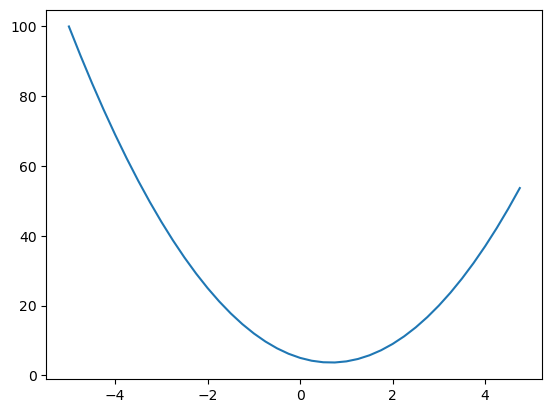

In [4]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)

plt.plot(xs, ys)

In [5]:
h = 0.0000001
x = 2/3
(f(x + h) - f(x)) / h

2.9753977059954195e-07

In [6]:
a = 2.0
b = - 3.0
c = 10.0
d = a * b + c
print(d)

4.0


In [7]:
h = 0.00001

a = 2.0
b = -3.0
c = 10.0

d1 = a * b + c
a += h
d2 = a * b + c

print('d1', d1)
print("d2", d2)
print("slope", (d2 - d1) / h)


d1 4.0
d2 3.9999699999999994
slope -3.000000000064062


In [20]:
class Value:

    def __init__(self, data, _children=(), _op="", label=""):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self.grad = 0
    
    def __repr(self):
        return f"ValueError{self.data}"
    
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), "+")
        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), "*")
        return out

a = Value(2.0, label="a")
b = Value(-3.0, label="b")
c = Value(10.0, label="c")
e = a * b; e.label = "e"
d = e + c; d.label = "d"
f = Value(-2.0, label="f")
L = d * f; L.label = "L"

In [14]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

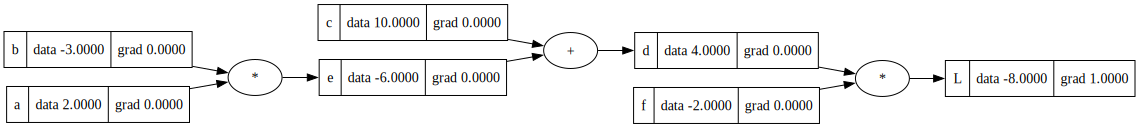

In [26]:
draw_dot(L)

In [24]:
def lol():
    a = Value(2.0, label="a")
    b = Value(-3.0, label="b")
    c = Value(10.0, label="c")
    e = a * b; e.label = "e"
    d = e + c; d.label = "d"
    f = Value(-2.0, label="f")
    L = d * f; L.label = "L"

    L1 = L.data
    h = 0.001

    a = Value(2.0, label="a")
    b = Value(-3.0, label="b")
    c = Value(10.0, label="c")
    e = a * b; e.label = "e"
    d = e + c; d.label = "d"
    f = Value(-2.0, label="f")
    L = d * f; L.label = "L"

    L2 = L.data + h

    print((L2 - L1) / h)

lol()

1.000000000000334


In [25]:
L.grad = 1

# Neuron

In [27]:
import math

In [36]:
class Value:

    def __init__(self, data, _children=(), _op="", label=""):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self.grad = 0
    
    def __repr(self):
        return f"ValueError{self.data}"
    
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), "+")
        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), "*")
        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1) 
        out = Value(t, (self,), 'tanh')
        return out

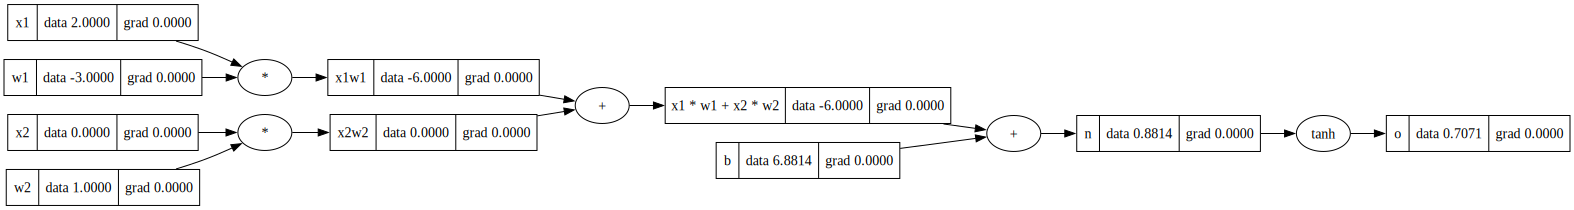

In [38]:
x1 = Value(2, label="x1")
x2 = Value(0.0, label="x2")

w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")

b = Value(6.881373, label="b")

x1w1 = x1 * w1; x1w1.label = "x1w1"
x2w2 = x2 * w2; x2w2.label = "x2w2"

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1 * w1 + x2 * w2"
n = x1w1x2w2 + b; n.label = "n"
o = n.tanh(); o.label = "o"

draw_dot(o)

In [84]:
class Node:

    def __init__(self, data, _children=(), _op="", label=""):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self.grad = 0
        self._backward = lambda: None
    
    def __repr(self):
        return f"ValueError{self.data}"
    
    def __add__(self, other):
        other = other if isinstance(other, Node) else Node(other)
        out = Node(self.data + other.data, (self, other), "+")

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        
        out._backward = _backward
        return out
    
    def __radd__(self, other):
        return self + other
    
    def __mul__(self, other):
        other = other if isinstance(other, Node) else Node(other)
        out = Node(self.data * other.data, (self, other), "*")
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        
        out._backward = _backward
        
        return out
    
    def __rmul__(self, other):
        return self * other
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int / float powers for now"
        out = Node(self.data ** other, (self,), f"**{other}")

        def _backward():
            self.grad += other * self.data ** (other-1) * out.grad

        out._backward = _backward
        return out
    
    def __sub__(self, other):
        return self + (-other)
    
    def __truediv__(self, other):
        return self * other ** -1
    
    def __neg__(self):
        return self * -1
    
    def exp(self):
        x = self.data
        out = Node(math.exp(x), (self,), 'exp')

        def _backward():
            self.grad += out.data * out.grad 
        out._backward = _backward
        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1) 
        out = Node(t, (self,), 'tanh')

        def _backward():
            self.grad += (1 - t ** 2) * out.grad
        out._backward = _backward

        return out
    
    def backward(self):
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()


In [85]:
x1 = Node(2, label="x1")
x2 = Node(0.0, label="x2")

w1 = Node(-3.0, label="w1")
w2 = Node(1.0, label="w2")

b = Node(6.881373, label="b")

x1w1 = x1 * w1; x1w1.label = "x1w1"
x2w2 = x2 * w2; x2w2.label = "x2w2"

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1 * w1 + x2 * w2"
n = x1w1x2w2 + b; n.label = "n"
# o = n.tanh(); o.label = "o"
e = (2 * n).exp()
o = (e - 1) / (e + 1)
o.label = "o"

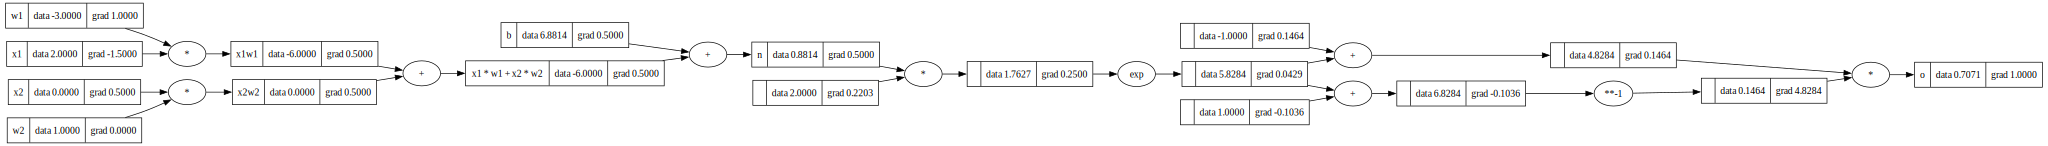

In [88]:
draw_dot(o)

In [87]:
o.backward()

# PyTorch